This script is used for modeling pH of the particluar geochemical system

In [1]:
import pickle
import numpy as np
import pandas as pd
import os
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_squared_error,r2_score

## The following are the ML models which can be used for trasinning
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import MinMaxScaler,StandardScaler

import timeit
import warnings
warnings.filterwarnings("ignore")


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
%matplotlib inline
import pandas as pd

In [3]:
import seaborn as sns
sns.set(style="darkgrid")

In [4]:
sns.set_context('talk')

In [5]:
dataFolder = os.getcwd()
file = '10_PC_02_LHS_500_54854_01_s1_G.csv' 
InsFile = os.path.join(dataFolder, file)
data = pd.read_csv(InsFile)

In [6]:
data.columns =[col.strip() for col in data.columns]
data['ratio'] = data['b(CaO)']/data['b(SiO2)']
inputColNames =['b(CaO)','b(SiO2)','b(H2O)']
inputColAqSiNames =['b(CaO)','b(SiO2)','b(H2O)','pH']

scaler =  StandardScaler().fit(data[inputColNames].values)
scalerSiaq = StandardScaler().fit(data[inputColAqSiNames].values)
#Split the dataset intotrain dataset and test dataset
trainData,testData = train_test_split(data,test_size=0.2, random_state=42,shuffle =True)
#Split the train dataset into 3 groups
# Group divider
group1_low =1.634
group2_low =0.673
group2_upper =1.634
group3_upper =0.673
train_group1 = trainData[trainData['ratio']>group1_low]  # with Portlandite, no Amor-S1
train_group1=train_group1.reset_index(drop=True)
train_group2 = trainData[(trainData['ratio']<=group2_upper) & (trainData['ratio']>=group2_low)]  # no Portlandite, no Amor-S1
train_group2=train_group2.reset_index(drop=True)
train_group3 = trainData[trainData['ratio']<group3_upper]     # no Portlandite, with Amor-S1
train_group3=train_group3.reset_index(drop=True)

train_GroupData = [train_group1,train_group2,train_group3]

test_group1 = testData[testData['ratio']>group1_low]  # with Portlandite, no Amor-S1
test_group1 = test_group1.reset_index(drop=True)

test_group2 = testData[(testData['ratio']<=group2_upper) & (testData['ratio']>=group2_low)]  # no Portlandite, no Amor-S1
test_group2 = test_group2.reset_index(drop=True)
test_group3 = testData[testData['ratio']<group3_upper]     # no Portlandite, with Amor-S1
test_group3 = test_group3.reset_index(drop=True)
test_GroupData = [test_group1,test_group2,test_group3]


In [7]:
## The target variables you want to simulate
# pH should be estiamted first because NSiO2 dpends on pH estimates for Group 2
targetColumnNames = ['pH','nSi(aq)'] #,'nCa(aq)','nCa(s)','nSi(aq)','nSi(s_reac)','nPortlandite']
## Save training infomation to a file
modeSumarryFileName = 'ModelTrainSummary.csv'


In [8]:
def GPyModel(xtrain,ytrain,OutFP):
    
    GPy_Model = GaussianProcessRegressor(kernel=Matern(length_scale=[1,1,1], nu=2.5), n_restarts_optimizer=9, normalize_y=True)
    #GPy_random = RandomizedSearchCV(estimator = GPy_Model, param_distributions = random_GPyModel, scoring = 'r2',n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    GPy_Model.fit(xtrain, ytrain)        
    pickle.dump(GPy_Model, open(OutFP, 'wb'))             
    # Cross Validation
    scores = outputModelTrainningScore(GPy_Model,xtrain,ytrain,nCV=10)     
    return GPy_Model,scores



In [9]:
def GPyModelAqSpecies(xtrain,ytrain,OutFP):
    
    GPy_Model = GaussianProcessRegressor(kernel=Matern(length_scale=[1,1,1,1], nu=2.5),alpha = 1.0e-7, n_restarts_optimizer=10, normalize_y=True)
    #GPy_random = RandomizedSearchCV(estimator = GPy_Model, param_distributions = random_GPyModel, scoring = 'r2',n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    GPy_Model.fit(xtrain, ytrain)        
    pickle.dump(GPy_Model, open(OutFP, 'wb'))             
    # Cross Validation
    scores = outputModelTrainningScore(GPy_Model,xtrain,ytrain,nCV=10)     

    return GPy_Model,scores


In [10]:
def outputModelTrainningScore(model,X,y,nCV=10):
    R2_score = cross_val_score(model, X, y,scoring='r2', cv=nCV)
    RMSE_score = cross_val_score(model, X, y,scoring='neg_root_mean_squared_error', cv=10)
    MAE_score = cross_val_score(model, X, y,scoring='neg_mean_absolute_error', cv=10) 
    R2_score_mean = R2_score.mean()
    RMSE_score_mean = RMSE_score.mean()
    MAE_score_mean = MAE_score.mean()
    return [R2_score_mean,RMSE_score_mean, MAE_score_mean] 


In [11]:
groupLst=[]
varLst = []
modelTypeLst = []
trainScore = []
dfTestResults = pd.DataFrame()
for i, (trainGroupData, testGroupData) in enumerate(zip(train_GroupData,test_GroupData)):
    group = 'group' +str(i+1)
    outFolder = os.path.join(dataFolder,'SavedModel',group)
    if not os.path.exists(outFolder):
         os.makedirs(outFolder)
    
    for col in targetColumnNames: 
        # CHeck the col is in the dataFrame
        if col not in trainGroupData.columns:
            sys.exit('The target column is not defined in the dataset, please check!')                
        
        print('Training With ===>', group,'Target==>',col)
        
        trainDataX=trainGroupData[inputColNames];
        trainDataY = trainGroupData[col]
        ## Check the max and min value of Y
        ## IF change of Y is less than 1%,
        ## then the target will be considered as constant, and 
        ## this value will be applied to the group
        
        X = trainDataX.values
        Y = trainDataY.values
        if '/' in col:
            fileCol = col.replace("/",'')
        else:
            fileCol = col            
        if Y.max()+Y.min() != 0:
            percnt = (Y.max()-Y.min())/(Y.max()+Y.min())*200.0
        else:
            percnt =0.0
        if percnt <1.0:
            fileName = os.path.join(outFolder,'const_'+fileCol+'.csv')
            constVal = (Y.max()+Y.min())*0.5
            tempdf = pd.DataFrame({'var':[col],'const':[constVal]})
            tempdf.to_csv(fileName,index=False)
            modelTypeLst.append('CONST')
            trainScore.append([0,0,0])
            groupLst.append(group)
            varLst.append(col)
            groupPredDF = pd.DataFrame({'testDataY':testGroupData[col].values,
                                        'predDataY':[constVal]*len(testGroupData),
                                        'predCI_low':[constVal]*len(testGroupData),
                                        'predCI_upp':[constVal]*len(testGroupData),
                                        'group':[group]*len(testGroupData),
                                        'var':[col]*len(testGroupData),
                                        'modelType':['CONST']*len(testGroupData)}) 
            if len(dfTestResults)==0:
                dfTestResults = groupPredDF
            else:
                dfTestResults = pd.concat([dfTestResults,groupPredDF],axis=0)
                
            continue
            
        # Check the correlation of each of dataX to DataY 
        corrLst = []
        for colX in trainDataX.columns:
            corr = trainDataX[colX].corr(trainDataY)
            corrLst.append(abs(corr))
        
        if max(corrLst)>=0.99:   # we use a linear model to simulate
            #give the X and Y for fiting a linear model                   
            regLinear = LinearRegression().fit(X, Y) 
            # conduct cross validation
            scores = outputModelTrainningScore(regLinear,X,Y,nCV=10)     
            trainScore.append(scores)
            groupLst.append(group)
            varLst.append(col)
            modelTypeLst.append('linear')  
            fileName = os.path.join(outFolder,'linear_'+fileCol+'.sav')
            pickle.dump(regLinear, open(fileName, 'wb'))    
            testX = testGroupData[inputColNames].values
            testY = testGroupData[col].values
            predY = regLinear.predict(testX)
            groupPredDF = pd.DataFrame({'testDataY':testY,
                                        'predDataY':predY,
                                        'predCI_low':predY,
                                        'predCI_upp':predY,
                                        'group':[group]*len(testGroupData),
                                        'var':[col]*len(testGroupData),
                                        'modelType':['Linear']*len(testGroupData)}) 
            
            if len(dfTestResults)==0:
                dfTestResults = groupPredDF
            else:
                dfTestResults = pd.concat([dfTestResults,groupPredDF],axis=0)
            
            continue
            
        if col == 'nSi(aq)' and group =='group2':  # need to add pH as another input to the model 
            trainDataX = trainGroupData[inputColAqSiNames ].reset_index(drop=True)
            X = trainDataX.values
            Y = trainDataY.values
            X_scaled = scalerSiaq.transform(X)  
            fileName = os.path.normpath( os.path.join( outFolder,'GPyModel_'+fileCol+'.sav' ) )             
            GPy,scores = GPyModelAqSpecies(X_scaled,Y,fileName)
            groupLst.append(group)
            varLst.append(col)
            modelTypeLst.append('GPyModel')  
            trainScore.append(scores)
            ## Get the pH value from the dfTestResults dataframe
            dfTemp = dfTestResults[(dfTestResults['group']=='group2') & (dfTestResults['var']=='pH')]
            testX = testGroupData[inputColNames].reset_index(drop=True)
            testX['pH'] = dfTemp['predDataY']
            testX_scaled = scalerSiaq.transform(testX.values)  
            testY = testGroupData[col].values
            predY,predYStd = GPy.predict(testX_scaled, return_std=True)
            CI_low = predY - predYStd
            CI_upp = predY + predYStd
            groupPredDF = pd.DataFrame({'testDataY':testY,
                                        'predDataY':predY,
                                        'predCI_low':CI_low,
                                        'predCI_upp':CI_upp,
                                        'group':[group]*len(testGroupData),
                                        'var':[col]*len(testGroupData),
                                        'modelType':['GPY']*len(testGroupData)}) 
            
            if len(dfTestResults)==0:
                dfTestResults = groupPredDF
            else:
                dfTestResults = pd.concat([dfTestResults,groupPredDF],axis=0)
            continue
        
        
        if col =='pH' and group =='group2':
            ## Use all the train dataset for this case      
            dataX=trainData[inputColNames].reset_index(drop=True)  
            dataY=trainData[col].reset_index(drop=True)
            X = dataX.values
            Y = dataY.values
            print(X.shape,Y.shape)
            
        fileName = os.path.normpath( os.path.join( outFolder,'GPyModel_'+fileCol+'.sav' ) )             
        X_scaled = scaler.transform(X)  
        GPy,scores = GPyModel(X_scaled,Y,fileName)
        groupLst.append(group)
        varLst.append(col)
        modelTypeLst.append('GPyModel')  
        trainScore.append(scores)
        
        testX = testGroupData[inputColNames].values
        testX_scaled = scaler.transform(testX) 
        testY = testGroupData[col].values
        predY,predYStd = GPy.predict(testX_scaled, return_std=True)
        CI_low = predY - predYStd
        CI_upp = predY + predYStd
        
        groupPredDF = pd.DataFrame({'testDataY':testY,
                                    'predDataY':predY,
                                    'predCI_low':CI_low,
                                    'predCI_upp':CI_upp,
                                    'group':[group]*len(testGroupData),
                                    'var':[col]*len(testGroupData),
                                    'modelType':['GPY']*len(testGroupData)}) 
        if len(dfTestResults)==0:
            dfTestResults = groupPredDF
        else:
            dfTestResults = pd.concat([dfTestResults,groupPredDF],axis=0)
        
        
ModelTrainSummary = pd.DataFrame({'group':groupLst,'var':varLst,'modelType':modelTypeLst})
ModelTrainMeasures = pd.DataFrame(trainScore,columns=['R2_mean','RMSE_mean','MAE_mean'])
ModelTrainSummary = pd.concat([ModelTrainSummary,ModelTrainMeasures],axis=1)
ModelTrainSummary.to_csv(modeSumarryFileName, index =False)

Training With ===> group1 Target==> pH
Training With ===> group1 Target==> nSi(aq)
Training With ===> group2 Target==> pH
(400, 3) (400,)
Training With ===> group2 Target==> nSi(aq)
Training With ===> group3 Target==> pH
Training With ===> group3 Target==> nSi(aq)


In [12]:
dfTestResults.to_csv('SimulatedReusltsWithTestDataset.csv',index=False)

In [13]:
def drawPlotsV2(trgVar,df,simulation,scale):
    
    fig, ax =plt.subplots(figsize=(8,8))
    df = df.sort_values(by=['testDataY'])
    axMax = max(df['testDataY'].max(),df['predDataY'].max())
    axMax =axMax +axMax*0.05
    axMin = min(df['testDataY'].min(),df['predDataY'].min())
    axMin = axMin - axMin*0.05
    x2= np.linspace(axMin,axMax,30);
    y2 = x2
    df1 = df[df['group']=='group1']
    df1 =df1.reset_index(drop=True)
    ax.fill_between(df1['testDataY'], df1['predCI_low'],  df1['predCI_upp'], alpha=0.6)
    ax.plot(df1['testDataY'],df1['predDataY'],'bo',markersize =12,label ='Group 1')
    df2 = df[df['group']=='group2']
    df2 =df2.reset_index(drop=True)
    ax.fill_between(df2['testDataY'], df2['predCI_low'],  df2['predCI_upp'], alpha=0.6)
    ax.plot(df2['testDataY'],df2['predDataY'],'go',markersize =6,label ='Group 2')
    df3 = df[df['group']=='group3']
    df3 =df3.reset_index(drop=True)
    ax.fill_between(df3['testDataY'], df3['predCI_low'],  df3['predCI_upp'], alpha=0.6)
    ax.plot(df3['testDataY'],df3['predDataY'],'yo',markersize =12,label ='Group 3')

    ax.plot(x2,y2,'r-',lw=3,label ='1:1 ratio')
    ax.legend (loc='best',ncol=5)           
    ax.set_xlim(axMin,axMax)
    ax.set_ylim(axMin,axMax)
    ax.legend (loc='best',ncol=2)
    if scale=='log':
        ax.set_xscale('log')
        ax.set_yscale('log')
    ax.set_title(simulation+ ' ====> '+trgVar)
    ax.set_xlabel('testDataY')
    ax.set_ylabel('PredDataY')    
        

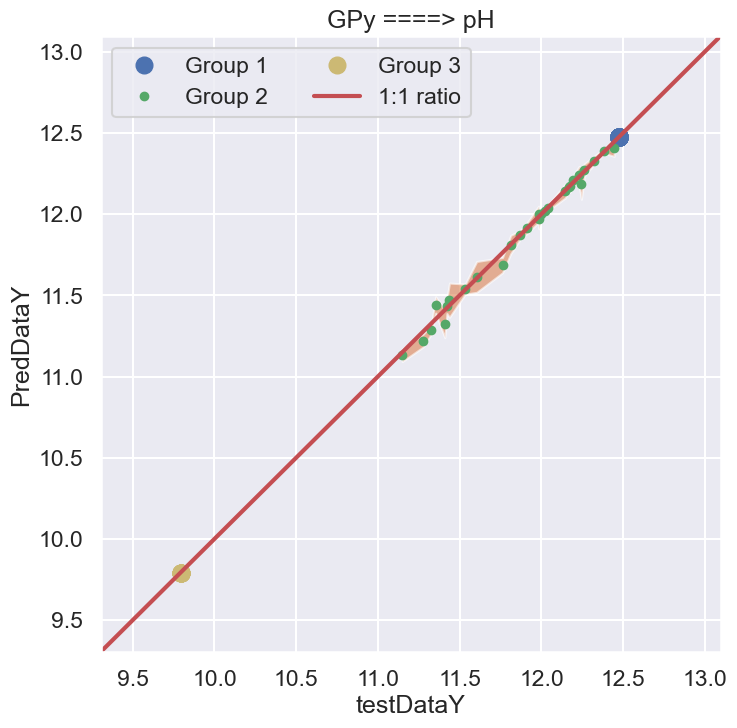

In [14]:
dfPlot = dfTestResults[dfTestResults['var']=='pH']
drawPlotsV2('pH',dfPlot,'GPy',scale='no')

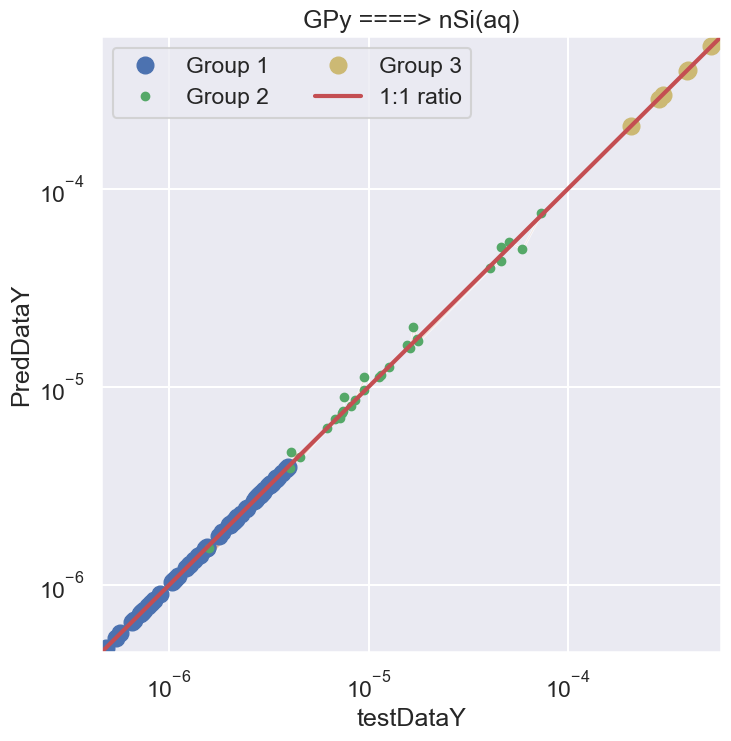

In [15]:
dfPlot = dfTestResults[dfTestResults['var']=='nSi(aq)']
drawPlotsV2('nSi(aq)',dfPlot,'GPy',scale='log')


In [17]:
dfTestResults = dfTestResults.reset_index(drop=True)

In [22]:
def drawPlotswithIndex(trgVar,df,simulation,scale):
    
    fig, ax =plt.subplots(figsize=(8,8))
    #df = df.sort_values(by=['testDataY'])
    #df = df.reset
    axMax = max(df['testDataY'].max(),df['predDataY'].max())
    axMax =axMax +axMax*0.05
    axMin = min(df['testDataY'].min(),df['predDataY'].min())
    axMin = axMin - axMin*0.05
    #x2= np.linspace(axMin,axMax,30);
    #y2 = x2
    
    ax.fill_between(df.index, df['predCI_low'],  df['predCI_upp'], alpha=0.6)
    ax.plot(df.index,df['predDataY'],'g-',markersize =6,label ='Predicted')
    ax.plot(df.index,df['testDataY'],'bo',markersize =6,label ='Test')

    ax.legend (loc='best',ncol=3)           
    #ax.set_xlim(axMin,axMax)
    ax.set_ylim(axMin,axMax)
    ax.legend (loc='best',ncol=2)
    if scale=='log':
        ax.set_yscale('log')
    ax.set_title(simulation+ ' ====> '+trgVar)
    ax.set_xlabel('data Points')
    ax.set_ylabel(trgVar)    
        

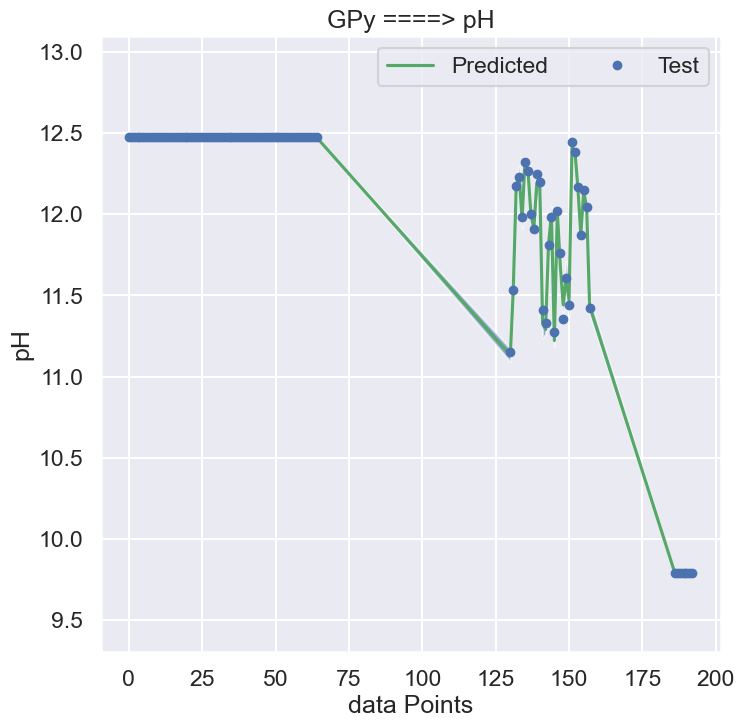

In [23]:
df = dfTestResults[dfTestResults['var']=='pH']
drawPlotswithIndex('pH',df,'GPy',scale='No')

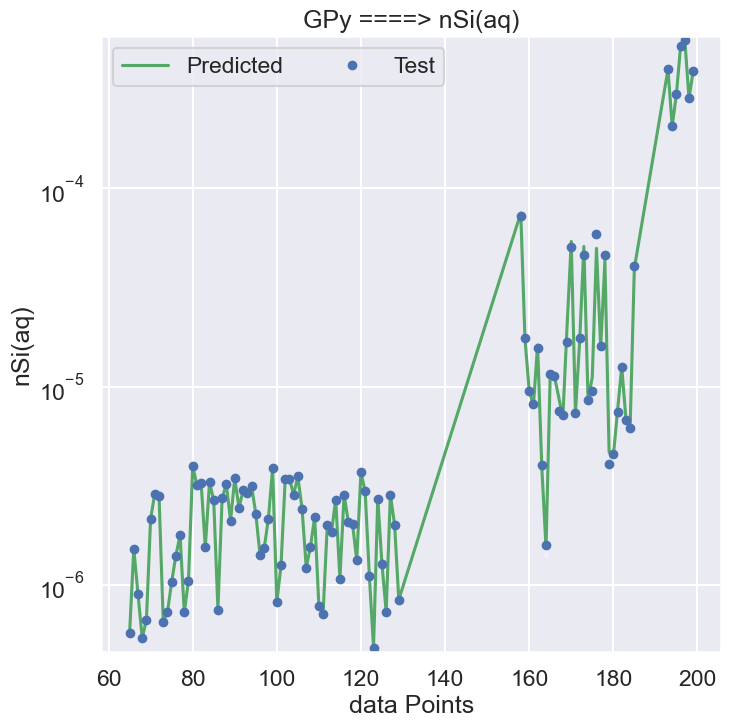

In [28]:
df = dfTestResults[dfTestResults['var']=='nSi(aq)']
drawPlotswithIndex('nSi(aq)',df,'GPy',scale='log')